In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

from collections import defaultdict

import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm
# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.metrics import jaccard_score
from sklearn.metrics.cluster import adjusted_rand_score

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

from customPalette import annotation_Level1_LowQFilt_sortednames, annotation_Level2_LowQFilt_sortednames

plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

# Specific modules
import requests
import re
import scanpy as sc
import anndata as ad

# Setting some parameters
warnings.filterwarnings("ignore")

pd.options.display.max_columns=300
pd.options.display.max_rows=1000

overwriteFigure = True

**Defining functions**

In [2]:
print("Main directory path: {}".format(here()))

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas


# Compare ATLAS annotation with external cell annotation

**List of PUBLIC datasets with available information for cell annotation**

* Terekhova2023: Healthy
* Perez2022: SLE + Healthy
* COMBAT2022: COVID + Flu + HC
* Ren2021: COVID + HC

In [3]:
fullAnnotationDF = pd.read_pickle(here('02_fromCellLineages_to_CellTypes/master_clusterAnnotDF_final.pkl'))
fullAnnotationDF.head()

,annotation_step_1,annotation_step_2,annotation_step_3,annotation_step_4,annotation_step_5,Level1,Level2
cellID,,,,,,,
SCGT00_L051_I53.3P_T0_AACCAACGTGGGATTG,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I58.3P_T0_ACCTGAAAGTGCCAGA,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I53.3P_T0_ACTATGGAGGCGCTCT,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I55.3P_T0_ACTTTCACATGGGTTT,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I52.3P_T0_ATCACAGTCATCGGGC,pDC,pDC,pDC,pDC,pDC,pDC,pDC


In [4]:
fullAnnotationDF = fullAnnotationDF[~fullAnnotationDF['Level1'].isin(['RBC', 'Platelets', 'Doublets', 'LowQuality_cells'])]

In [5]:
# Sorting celltypes to match our criteria

public_annotatedData_Dict = {   
    "Terekhova2023" : ("Cluster_names", 
                       ['B cells', 'Myeloid cells',
                        'CD4+ T cells', 'TRAV1-2- CD8+ T cells',  'MAIT cells', 'gd T cells', 'DN T cells', 'NK cells',  'Progenitor cells']),

# LOW RES --> cg_cov
# ['B',  'PB', 'pDC', 'cDC', 'cM', 'ncM', 'T4', 'T8', 'NK', 'Prolif', 'Progen']    
    "Perez2022" : ("merged_cov",
                      ['B', 'B_naive', 'B_mem', 'B_atypical',  'B_plasma', 'PB',
                       'pDC','cDC', 'cM', 'ncM',
                       'T4', 'T4_naive', 'T4_em','T4_reg', 
                       'T8', 'T8_naive', 'CytoT_GZMH+', 'CytoT_GZMK+', 'T_mait',
                       'NK', 'NK_bright', 'NK_dim', 
                       'Progen', 'Prolif']),   
    
    "COMBAT2022" : ("author_annotation_level_2", # also author_annotation_level_3, but not biologically relevant
                   [ 'B.INT','B.MEM', 'PB', 
                    'pDC','cDC',   'cMono', 'ncMono', 'cMono.cyc',
                    'CD4.NAIVE', 'CD4.TCM',  'CD4.TEM/TEMRA',  'CD4.TEFF', 'CD4.TREG',
                    'CD8.NAIVE',  'CD8.TCM', 'CD8.TCM.CCL5', 'CD8.TEM', 'CD8.TEMRA',  'CD8.TEFF', 'CD8.TREG', 'CD8.mitohi', 'iNKT', 
                    'DP', 'MAIT', 'DN', 'GDT.VD2neg', 'GDT.VD2', 'CD4.TEFF.prolif',  'CD8.TEFF.prolif', 
                    'NK.CD16hi', 'NK.CD56hi.CD16int.XCL1/2', 'NK.CD16int', 'NK.mitohi', 'NK.cyc',
                    'HSC', 'cMono.PLT',  'PLT', 'RET', 'Mast', 'nan']), 
    
# LOW RES --> cell_type
#  ['B cell', 'plasma cell', 'dendritic cell', 'CD14-positive, CD16-negative classical monocyte', 'CD14-positive, CD16-positive monocyte', 'monocyte',
# 'mature alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'mature gamma-delta T cell','natural killer cell', 'neutrophil', 'megakaryocyte','macrophage' ]    
    
    "Ren2021" : ("celltype", # also celltype, (higher resolution) -- 57 levels
             [
 'B_c01-TCL1A', 'B_c04-SOX5-TNFRSF1B', 'B_c02-MS4A1-CD27', 'B_c03-CD27-AIM2', 'B_c05-MZB1-XBP1',    
                 'DC_c4-LILRA4',
'DC_c1-CLEC9A', 'DC_c2-CD1C',    
'Mono_c3-CD14-VCAN',  'Mono_c1-CD14-CCL3', 'Mono_c2-CD14-HLA-DPB1', 'Mono_c5-CD16',  'Mono_c4-CD14-CD16',
'T_CD4_c01-LEF1','T_CD4_c06-NR4A2',  'T_CD4_c11-GNLY', 'T_CD4_c07-AHNAK', 'T_CD4_c04-ANXA2','T_CD4_c12-FOXP3',
                 'T_CD4_c02-AQP3', 'T_CD4_c03-ITGA4', 'T_CD4_c05-FOS',  'T_CD4_c08-GZMK-FOS_h', 'T_CD4_c09-GZMK-FOS_l', 'T_CD4_c10-IFNG', 
'T_CD8_c01-LEF1',  'T_CD8_c03-GZMK','T_CD8_c07-TYROBP','T_CD8_c05-ZNF683', 'T_CD8_c02-GPR183', 'T_CD8_c04-COTL1', 
                 'T_CD8_c06-TNF',   'T_CD8_c13-HAVCR2',
 'T_gdT_c14-TRDV2','T_CD8_c09-SLC4A10','T_CD8_c08-IL2RB', 
  'NK_c01-FCGR3A', 'NK_c02-NCAM1',                   
 'B_c06-MKI67',  'T_CD4_c13-MKI67-CCL5_l', 'T_CD4_c14-MKI67-CCL5_h', 'T_CD8_c10-MKI67-GZMK',  'T_CD8_c11-MKI67-FOS', 'T_CD8_c12-MKI67-TYROBP', 'NK_c03-MKI67',
             ]
                )    
}

## Unify annotations

### Terekhova2023

In [6]:
# Group our Level2 annotations based on the external ones to satisfy the same level of granularity

annotation_Level_Terekhova2023 = {
    "B_Lympchoytes": ['B_Transitional', 'B_Naive', 'B_Naive_activated', 'B_Memory_ITGAX', 'B_Memory_unswitched', 'B_Memory_switched','B_IFNresponder', 'Plasma_XBP1', 'Plasma_IGHA', 'Plasma_IGHG', 'Plasma_Proliferative'], 
    "Myeloid_cells" : ['pDC', 'Mono_classical', 'Mono_nonClassical', 'Mono_inflammatory', 'Mono_IFNresponse', 'Mono_regulatory', 'cDC1', 'cDC2', 'cDC3', 'DC4', 'DC5', 'DC_CCR7', 'DC_Proliferative'],
    "T_CD4_cells": ['T_CD4_Naive','T_CD4_CM', 'T_CD4_CM_ribo', 'T_CD4_EM', 'T_CD4_EMRA', 'T_CD4_eff', 'Th0','Th1', 'Th2', 'Tregs', 'Tregs_activated'],
    "T_CD8_cells" : ['T_CD8_Naive','T_CD8_CM', 'T_CD8_CM_stem', 'T_CD8_EM_CX3CR1high', 'T_CD8_EM_CX3CR1int',  'T_CD8_eff_HOBIT', 'T_CD8_IFNresponse', 'T_CD8_Mem_cytotoxic', 'T_CD8_activated', 'T_CD8_arrested'],
    "MAIT_cells" : ['MAIT', 'MAIT_17'],
    "T_gd_cells": ['gdT_V1', 'gdT_V2_Vγ9'],
    "T_cycling" : ['T_Proliferative'],
    'NK cells' : ['NK_CD16high', 'NK_CD56dimCD16', 'NK_CD56high', 'NK_IFN1response', 'NK_adaptive', 'NK_lowRibocontent', 'NK_Proliferative'],
    "Progenitors" : ['HSC_LMP', 'HSC_MEMP', 'HSC_MMP','B_Progenitors',  'T_Progenitors']
}

annotation_Level_Terekhova2023 = {"\n".join(value): value for key, value in annotation_Level_Terekhova2023.items()}

fullAnnotationDF["Level_Terekhova2023"] = fullAnnotationDF["Level2"].astype('str')

# Renaming
annotation_Level_Terekhova2023_rev = {old_label: new_label for new_label, old_labels in annotation_Level_Terekhova2023.items() for old_label in old_labels}
fullAnnotationDF['Level_Terekhova2023'] = fullAnnotationDF['Level2'].map(annotation_Level_Terekhova2023_rev)
fullAnnotationDF['Level_Terekhova2023'] = pd.Categorical(fullAnnotationDF['Level_Terekhova2023'], categories=list(annotation_Level_Terekhova2023.keys()), ordered=True)

### Perez2022

In [7]:
# Group our Level2 annotations based on the external ones to satisfy the same level of granularity

annotation_Level_Perez2022 = {
    "B_cells": ['B_Naive', 'B_Naive_activated','B_Transitional'],
    "B_Mem": ['B_Memory_unswitched', 'B_Memory_switched','B_IFNresponder'],
    "Baty" : ['B_Memory_ITGAX'],
    "Plasma" : ['Plasma_XBP1', 'Plasma_IGHA', 'Plasma_IGHG'], 
    'pDC' : ['pDC'],
    "DC" : ['cDC1', 'cDC2', 'cDC3', 'DC4', 'DC5', 'DC_CCR7'],
    "Mono_classical" : ['Mono_classical', 'Mono_inflammatory', 'Mono_IFNresponse', 'Mono_regulatory'],
    "Mono_nonClassical" : ['Mono_nonClassical'],
    "T_CD4_Naive" : ["T_CD4_Naive", 'T_CD4_CM', 'T_CD4_CM_ribo'],
    "T4_eff":['T_CD4_EM', 'T_CD4_EMRA', 'T_CD4_eff', 'Th0','Th1', 'Th2'],
    "Tregs" : ['Tregs', 'Tregs_activated'],
    "T_CD8_Naive" : ["T_CD8_Naive"],
    "T_CD8a" : ['T_CD8_CM', 'T_CD8_CM_stem', 'T_CD8_EM_CX3CR1high', 'T_CD8_EM_CX3CR1int',  'T_CD8_eff_HOBIT', 'T_CD8_IFNresponse', 'T_CD8_Mem_cytotoxic', 'T_CD8_activated'],
    "T_CD8b" : ['T_CD8_arrested'],    
    "UTC":['MAIT', 'MAIT_17', 'gdT_V1', 'gdT_V2_Vγ9'],
    'NKbright cells' : ['NK_CD56high'],
    "NKdim" : ['NK_CD16high', 'NK_CD56dimCD16', 'NK_IFN1response', 'NK_adaptive', 'NK_lowRibocontent'],
    "Cycling_cells" : ['Plasma_Proliferative', 'T_Proliferative', 'NK_Proliferative', 'DC_Proliferative'],
    "Progenitors" : ['HSC_LMP', 'HSC_MEMP', 'HSC_MMP','B_Progenitors',  'T_Progenitors']
}

annotation_Level_Perez2022 = {"\n".join(value): value for key, value in annotation_Level_Perez2022.items()}

# Renaming
annotation_Level_Perez2022_rev = {old_label: new_label for new_label, old_labels in annotation_Level_Perez2022.items() for old_label in old_labels}
fullAnnotationDF['Level_Perez2022'] = fullAnnotationDF['Level2'].map(annotation_Level_Perez2022_rev)
fullAnnotationDF['Level_Perez2022'] = pd.Categorical(fullAnnotationDF['Level_Perez2022'], categories=list(annotation_Level_Perez2022.keys()), ordered=True)

### COMBAT2022

In [8]:
# Group our Level2 annotations based on the external ones to satisfy the same level of granularity
# For annot_level2

annotation_Level_COMBAT2022 = {
    "B_cells": ['B_Transitional', 'B_Naive', 'B_Naive_activated', 'B_Memory_ITGAX', 'B_Memory_unswitched', 'B_Memory_switched','B_IFNresponder'],
    "Plasma" : ['Plasma_XBP1', 'Plasma_IGHA', 'Plasma_IGHG', 'Plasma_Proliferative'], 
        "pDC" : ['pDC'],
    "DC" : ['cDC1', 'cDC2', 'cDC3', 'DC4', 'DC5', 'DC_CCR7',  'DC_Proliferative'],
        "Mono_classical" : ['Mono_classical','Mono_inflammatory', 'Mono_IFNresponse', 'Mono_regulatory'],
    "Mono_nonClassical" : ['Mono_nonClassical'],
    "T_CD4_Naive" : ["T_CD4_Naive"],
    "T_CD4_CM" : ['T_CD4_CM', 'T_CD4_CM_ribo','T_CD4_EM', 'Th0','Th1', 'Th2'],
    "T_CD4_EMRA" : ['T_CD4_EMRA'],
    'T_CD4_eff' : ["T_CD4_eff"],
    "Tregs" : ['Tregs', 'Tregs_activated'],
    "T_CD8_Naive" : ["T_CD8_Naive"],
    "T_CD8_CM" : ["T_CD8_CM", 'T_CD8_CM_stem'],
    "T_CD8_EM" : ['T_CD8_EM_CX3CR1high', 'T_CD8_EM_CX3CR1int', 'T_CD8_eff_HOBIT', 'T_CD8_IFNresponse', 'T_CD8_Mem_cytotoxic', 'T_CD8_activated', 'T_CD8_arrested'],
    "MAIT" : ['MAIT', 'MAIT_17'],
    'gdT_V1' : ['gdT_V1'],
    "gdT_V2_Vγ9" : [ 'gdT_V2_Vγ9'],
     'T_Proliferative' : [ 'T_Proliferative'],
    'NK_CD16high' : ['NK_CD16high', 'NK_CD56dimCD16', 'NK_IFN1response','NK_lowRibocontent', 'NK_adaptive'],
    "NK_CD56high" :[ 'NK_CD56high'],
    'NK_Proliferative' : ['NK_Proliferative'],
    "Progenitors" : ['HSC_LMP', 'HSC_MEMP', 'HSC_MMP','B_Progenitors',  'T_Progenitors']    
}

annotation_Level_COMBAT2022 = {"\n".join(value): value for key, value in annotation_Level_COMBAT2022.items()}


fullAnnotationDF["Level_COMBAT2022"] = fullAnnotationDF["Level2"].astype('str')

# Renaming
annotation_Level_COMBAT2022_rev = {old_label: new_label for new_label, old_labels in annotation_Level_COMBAT2022.items() for old_label in old_labels}
fullAnnotationDF['Level_COMBAT2022'] = fullAnnotationDF['Level2'].map(annotation_Level_COMBAT2022_rev)
fullAnnotationDF['Level_COMBAT2022'] = pd.Categorical(fullAnnotationDF['Level_COMBAT2022'], categories=list(annotation_Level_COMBAT2022.keys()), ordered=True)

### Ren2021

In [9]:
annotation_Level_Ren2021 = {
 'B': ['B_Naive', 'B_Transitional', 'B_Naive_activated', 'B_Memory_unswitched', 'B_IFNresponder'],
 'B_Memory_ITGAX': ['B_Memory_ITGAX'],
 'B_Memory_switched': ['B_Memory_switched'],
 'Plasma': ['Plasma_XBP1', 'Plasma_IGHA', 'Plasma_IGHG'],
 'pDC': ['pDC'],
 'cDC1': ['cDC1'],
 'cDC': ['cDC2', 'cDC3', 'DC4', 'DC5', 'DC_CCR7'],
 'Mono_classical': ['Mono_classical', 'Mono_regulatory', 'Mono_IFNresponse'],
 'Mono_inflammatory': ['Mono_inflammatory'],
 'Mono_nonClassical': ['Mono_nonClassical'],
 'T_CD4_Naive': ['T_CD4_Naive'],
 'T_CD4_CM': ['T_CD4_CM'],
 'T_CD4_CM_ribo': ['T_CD4_CM_ribo'],
 'T_CD4_EM': ['T_CD4_EM', 'T_CD4_eff'],
 'T_CD4_EMRA': ['T_CD4_EMRA'],
 'Th0': ['Th0'],
 'Th1': ['Th1'],
 'Th2': ['Th2'],
 'Tregs': ['Tregs'],
 'Tregs_activated': ['Tregs_activated'],
 'T_CD8_Naive': ['T_CD8_Naive'],
 'T_CD8_CM': ['T_CD8_CM'],
 'T_CD8_CM_stem': ['T_CD8_CM_stem'],
 'T_CD8_EM_CX3CR1high': ['T_CD8_EM_CX3CR1high','T_CD8_IFNresponse'],
 'T_CD8_EM_CX3CR1int': ['T_CD8_EM_CX3CR1int'],
 'T_CD8_eff_HOBIT': ['T_CD8_eff_HOBIT'],
 'T_CD8_Mem_cytotoxic': ['T_CD8_Mem_cytotoxic', 'T_CD8_activated', 'T_CD8_arrested'],
 'gdT_V1': ['gdT_V1'],
 'gdT_V2_Vγ9': ['gdT_V2_Vγ9'],
 'MAIT': ['MAIT', 'MAIT_17'],
 'NK_CD56high': ['NK_CD56high'],
 'NK_CD16high': ['NK_CD16high', 'NK_CD56dimCD16', 'NK_IFN1response', 'NK_adaptive', 'NK_lowRibocontent'],
 'HSC': ['HSC_LMP', 'HSC_MEMP', 'HSC_MMP'],
"Progenitors" : ['B_Progenitors',  'T_Progenitors'],
    "Cycling_cells" : ['Plasma_Proliferative', 'T_Proliferative', 'NK_Proliferative', 'DC_Proliferative']
}


annotation_Level_Ren2021 = {"\n".join(value): value for key, value in annotation_Level_Ren2021.items()}

fullAnnotationDF["Level_Ren2021"] = fullAnnotationDF["Level2"].astype('str')

# Renaming
annotation_Level_Ren2021_rev = {old_label: new_label for new_label, old_labels in annotation_Level_Ren2021.items() for old_label in old_labels}
fullAnnotationDF['Level_Ren2021'] = fullAnnotationDF['Level2'].map(annotation_Level_Ren2021_rev)
fullAnnotationDF['Level_Ren2021'] = pd.Categorical(fullAnnotationDF['Level_Ren2021'], categories=list(annotation_Level_Ren2021.keys()), ordered=True)

## Comparison annotations

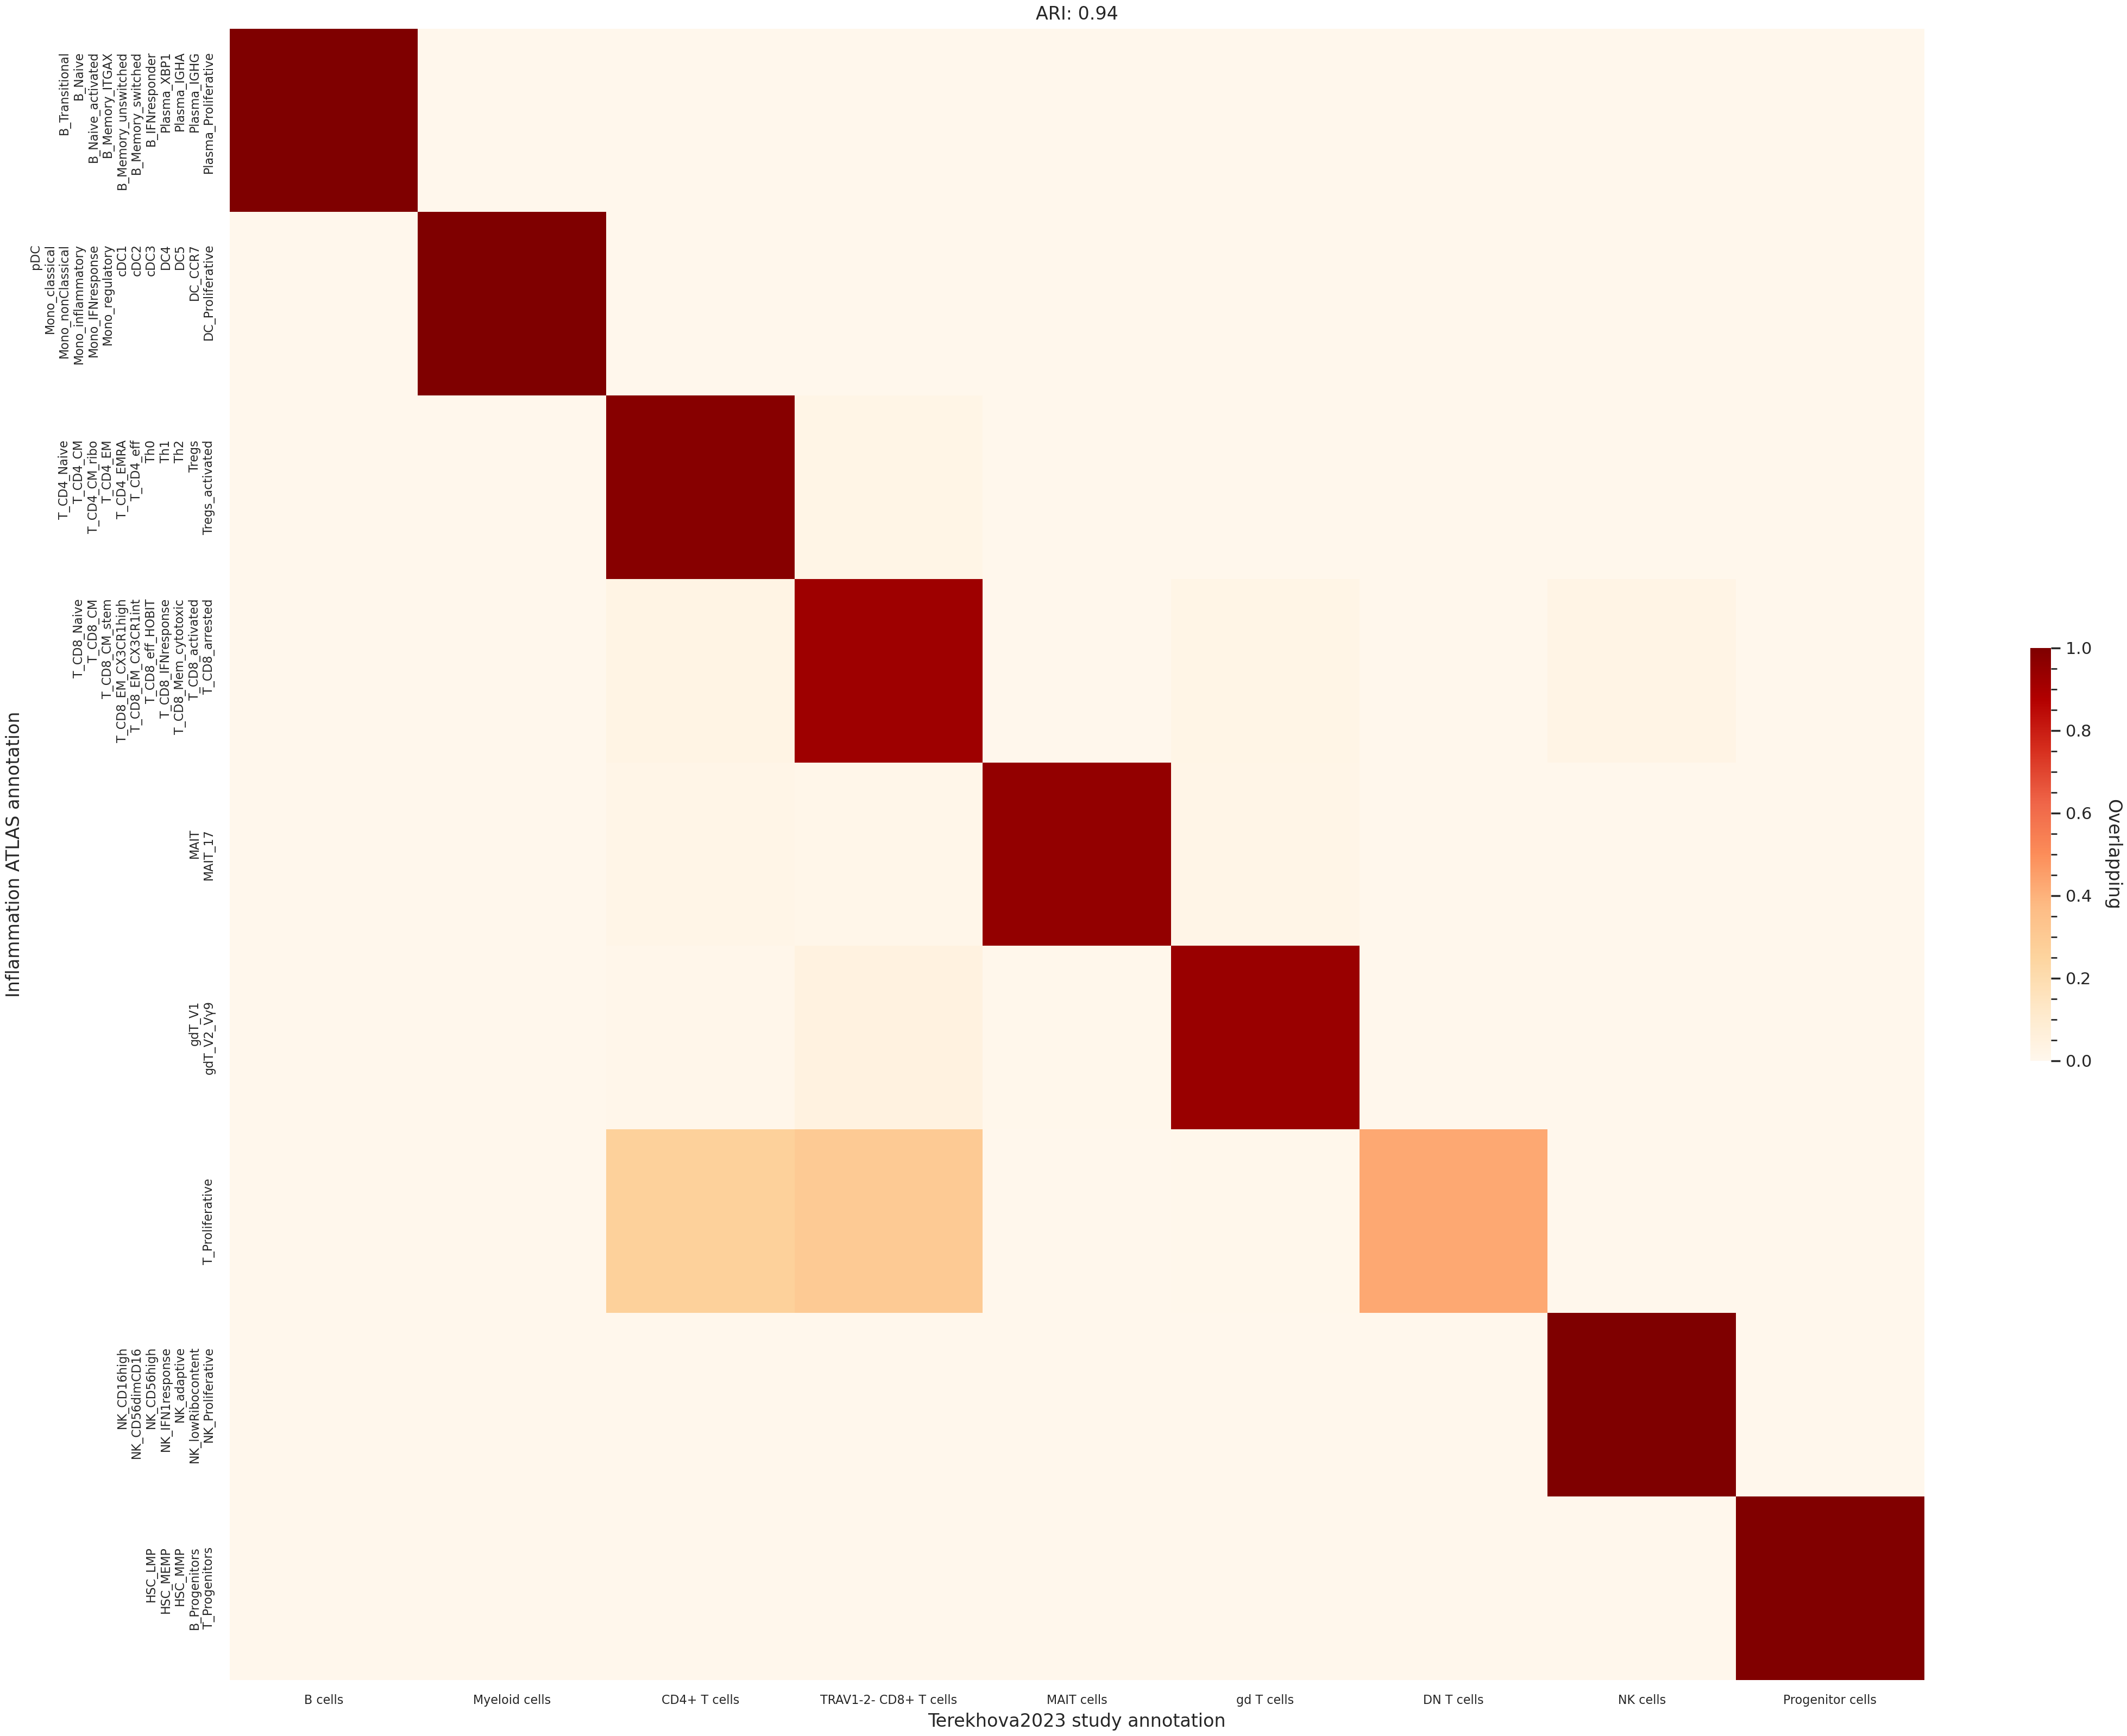

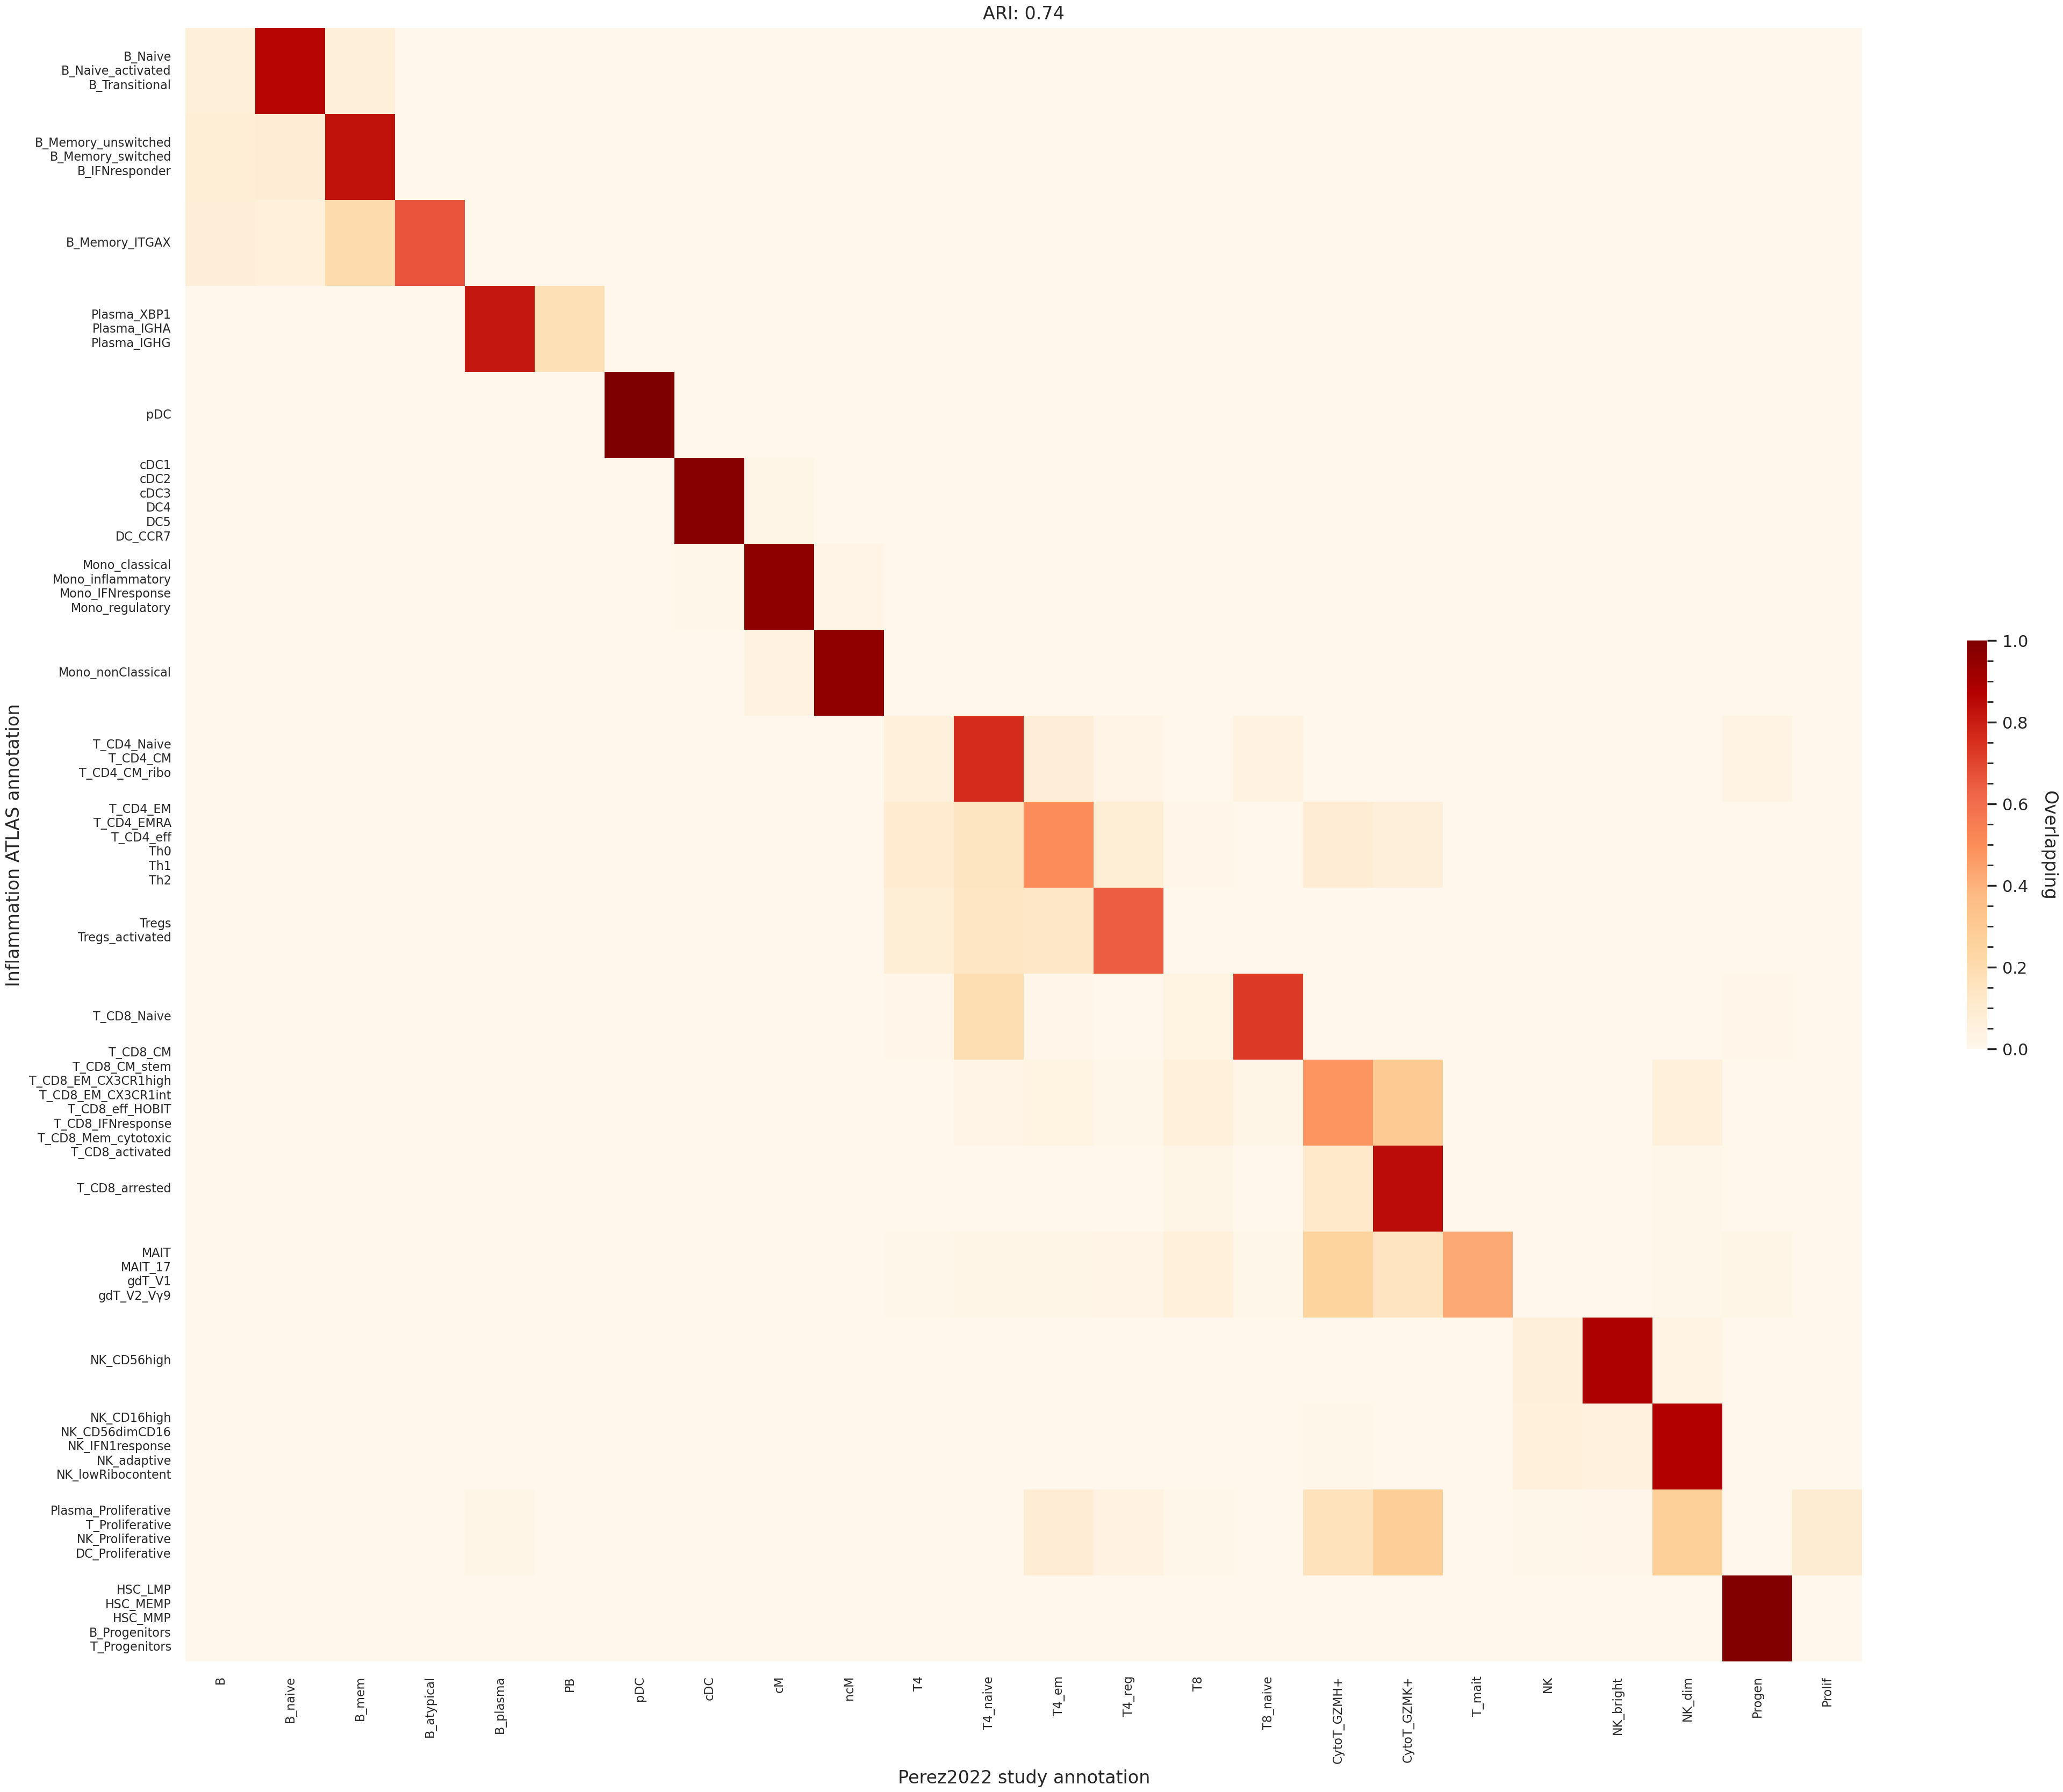

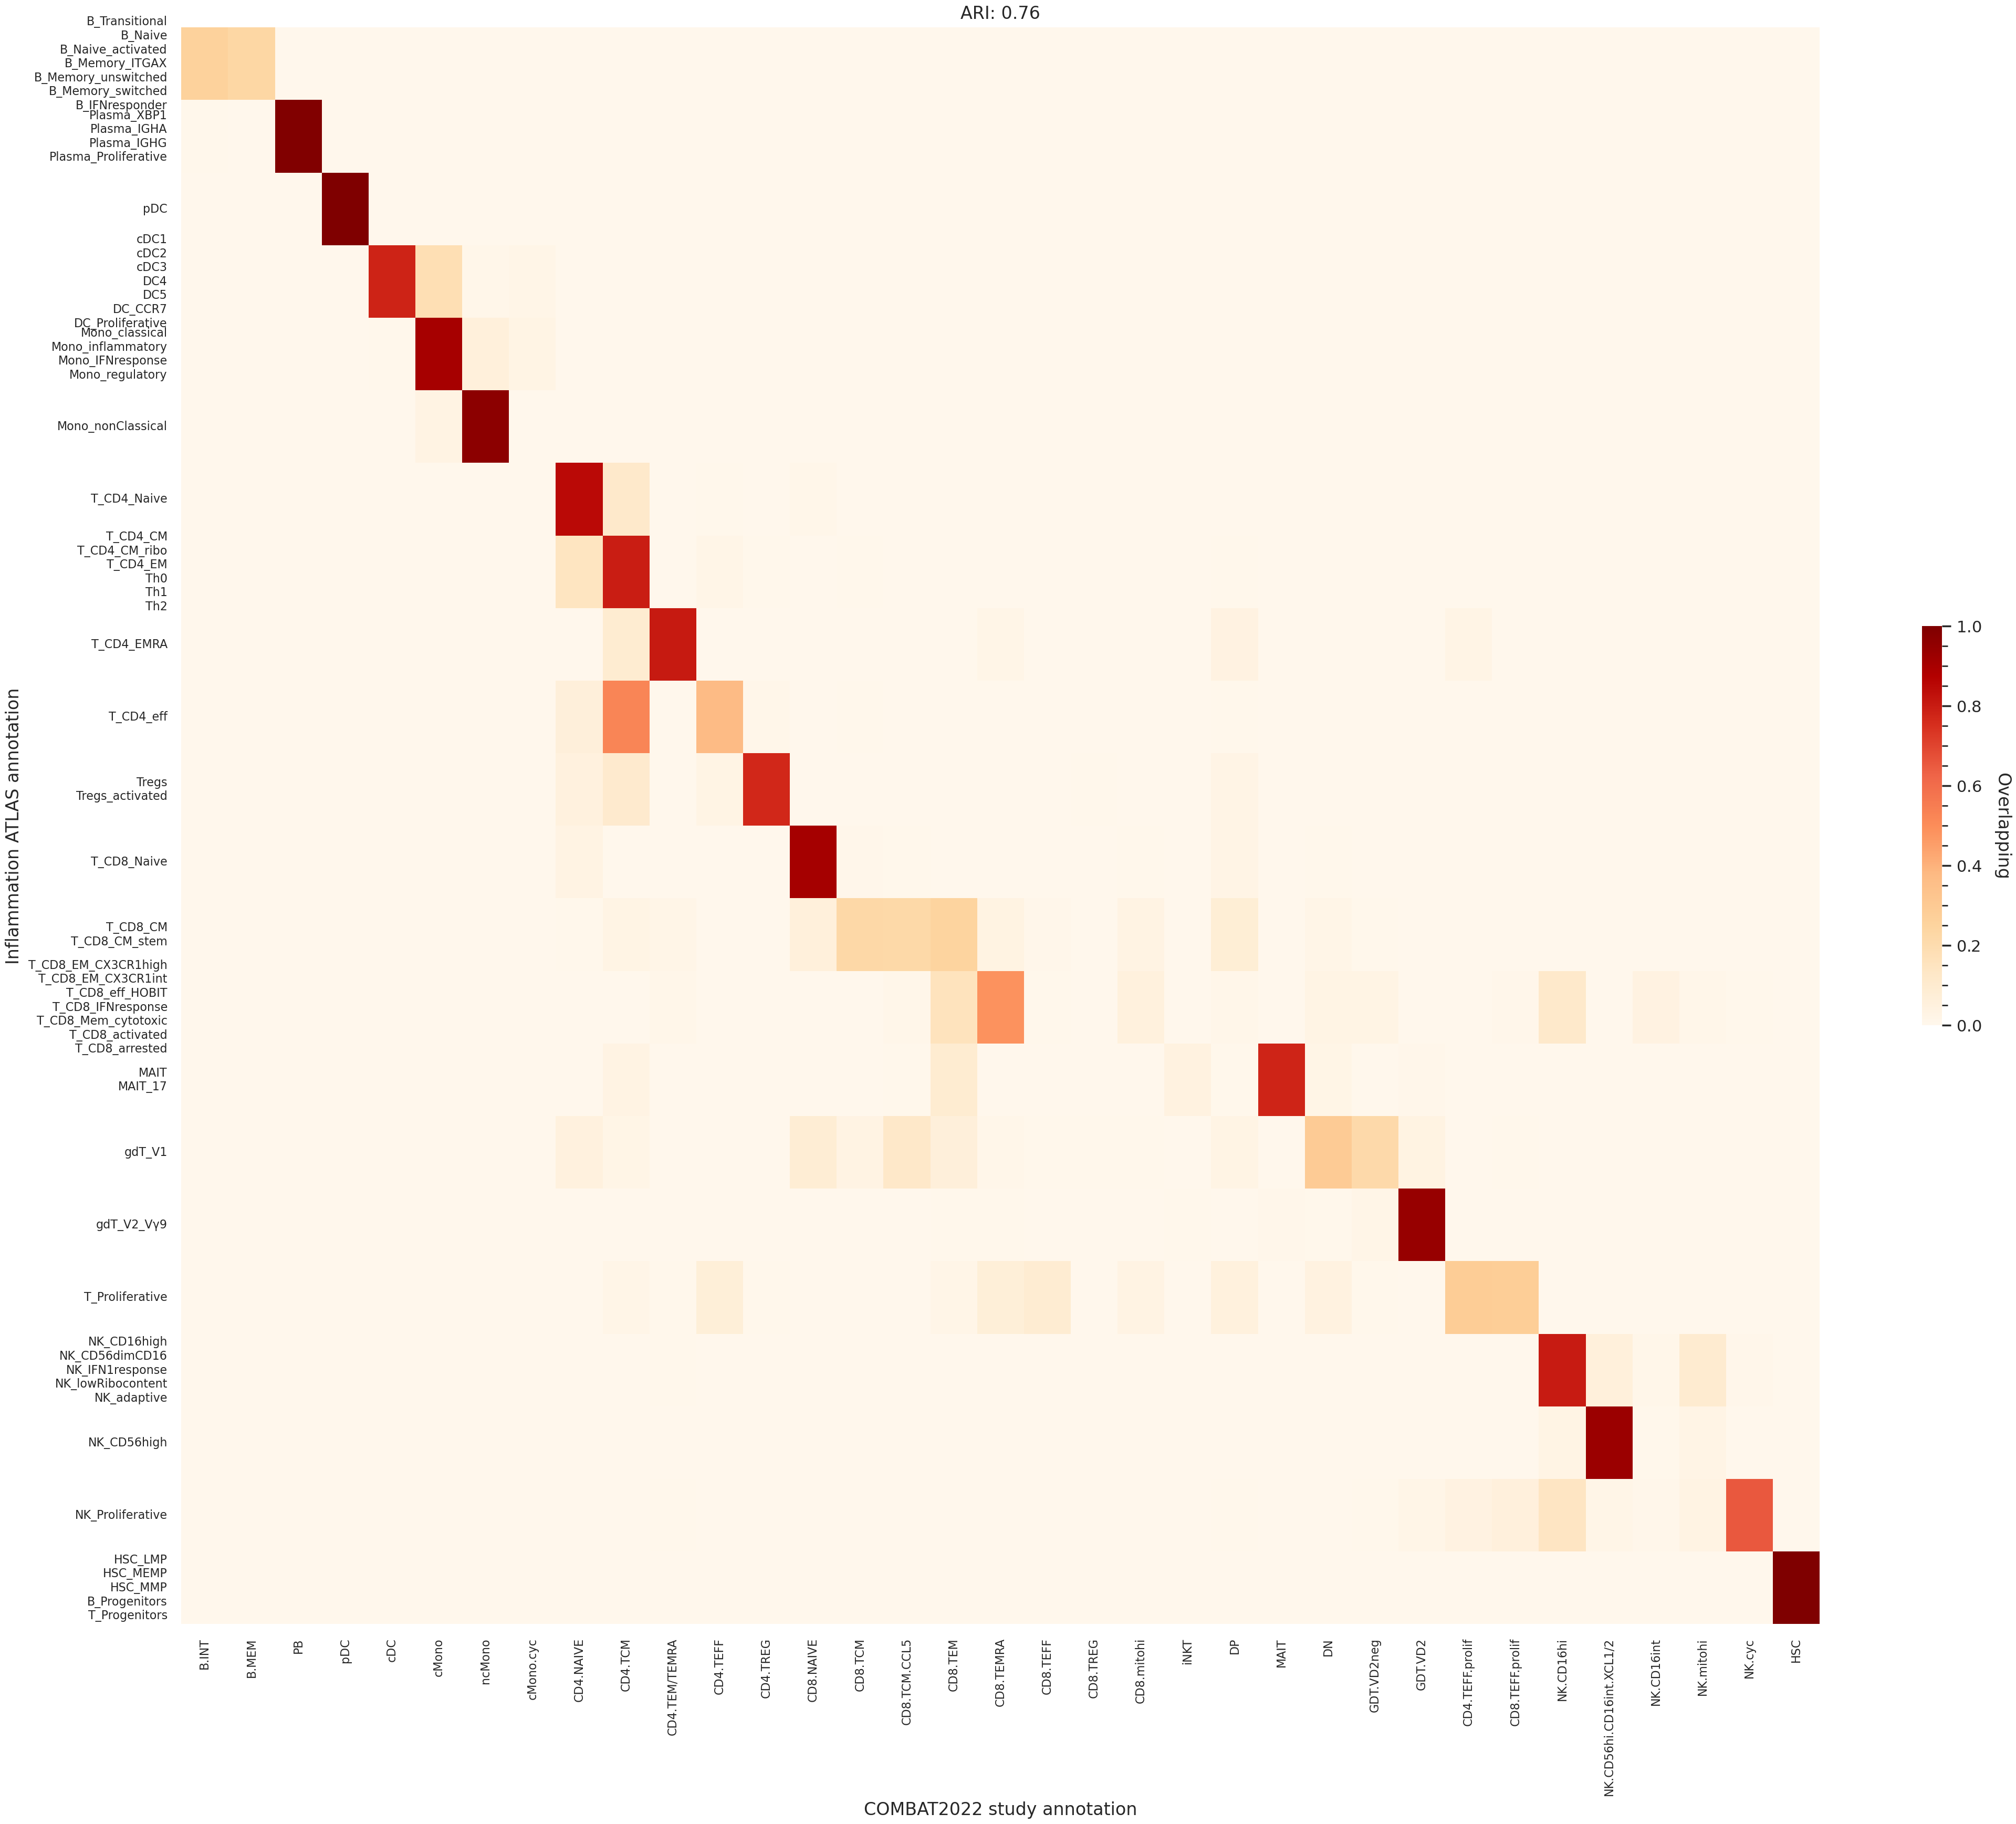

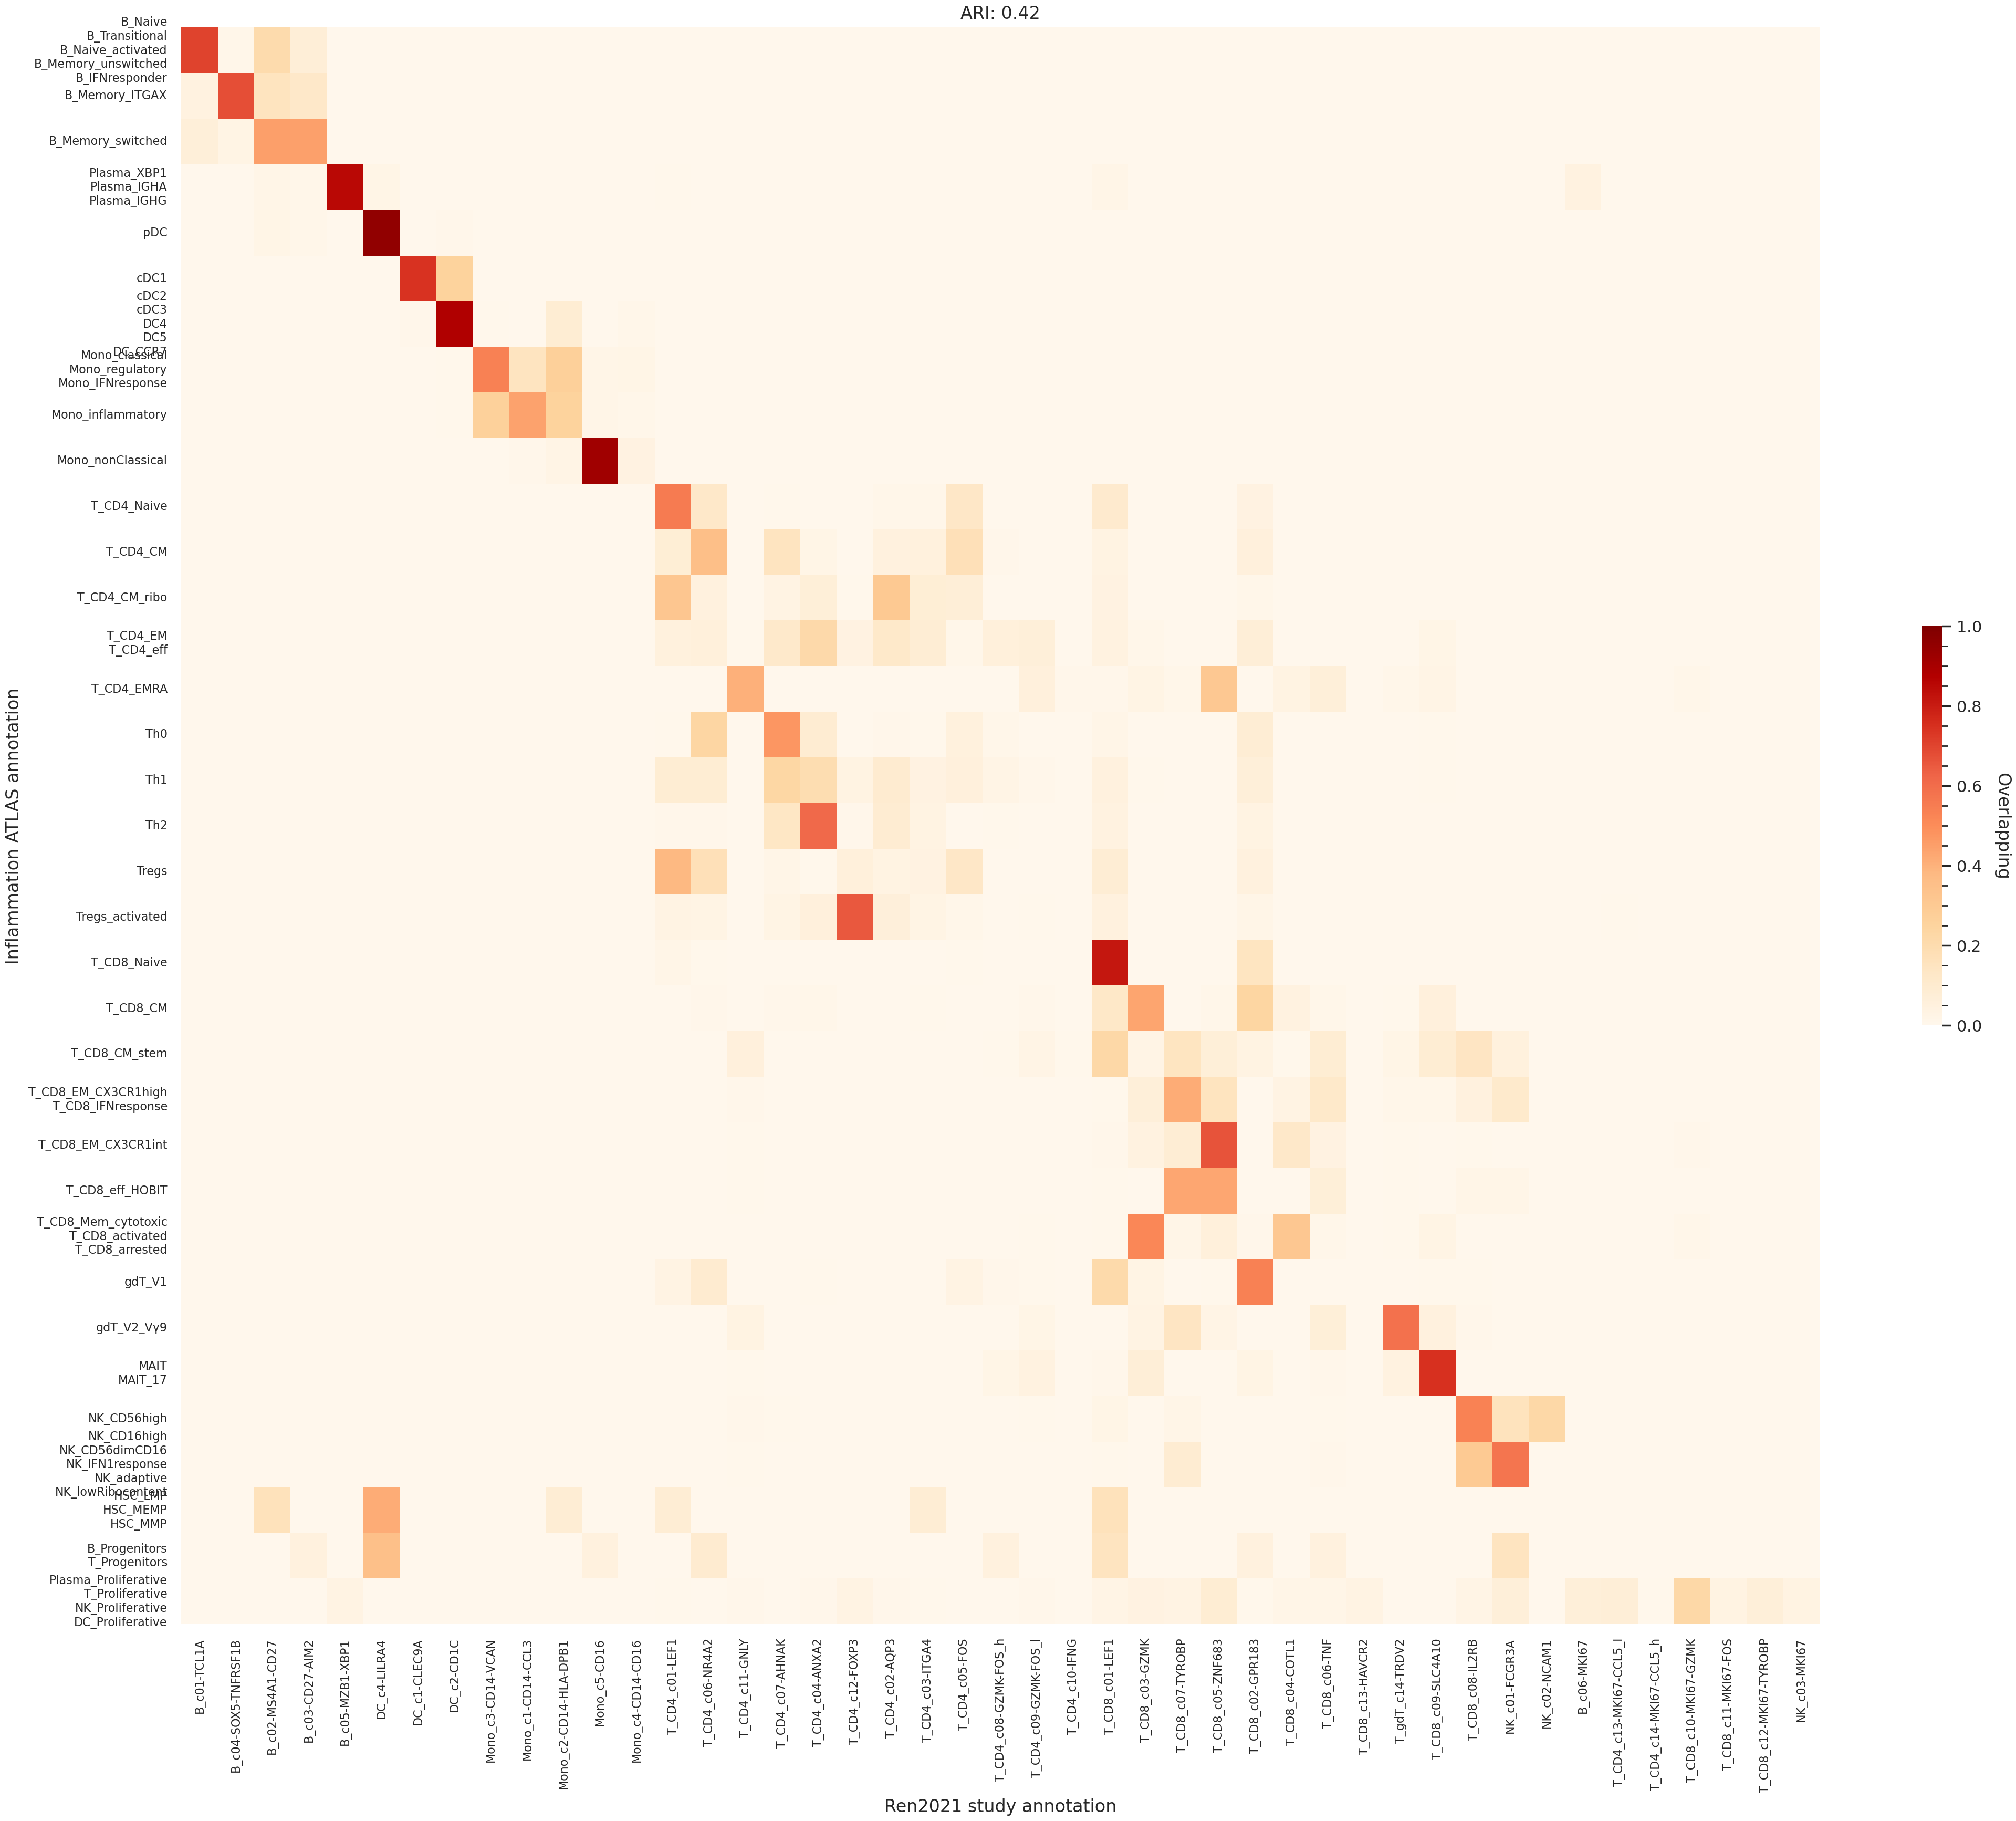

In [10]:
for studyID, value in public_annotatedData_Dict.items():
    external_annot_var, external_annot_sortedList = value

    level_study = "Level_" + studyID
    selCol = [level_study]
    selCol += [external_annot_var]
    
    cellDF = pd.read_pickle(here('01_data_processing/results/extended_obs/{}_obs.pkl'.format(studyID)))

    if studyID == "Perez2022":
        cellDF['ct_cov'] = cellDF['ct_cov'].astype(str)
        cellDF['cg_cov'] = cellDF['cg_cov'].astype(str)
        cellDF.replace('nan', np.nan, inplace=True)
        cellDF['merged_cov'] = cellDF['ct_cov'].fillna(cellDF['cg_cov'])
        cellDF['merged_cov'] = cellDF['merged_cov'].astype('category')
    
    if studyID == "Terekhova2023":
        cellDF = pd.read_pickle(here('01_data_processing/results/extended_obs/Terekhova2023_obs.pkl'))
    
    # Subset the DataFrame based on external_annot_var
    if studyID == "COMBAT2022":
        cellDF = cellDF[~cellDF[external_annot_var].isin(['cMono.PLT', 'PLT', 'RET', 'Mast', 'nan'])]
        external_annot_sortedList = [category for category in external_annot_sortedList if category not in ['cMono.PLT', 'PLT', 'RET', 'Mast', 'nan']]

    if studyID == "Ren2021":
        cellDF = cellDF[~cellDF["cell_type"].isin(['macrophage', 'megakaryocyte', 'neutrophil'])]
        external_annot_sortedList = [category for category in external_annot_sortedList if category not in ['macrophage', 'megakaryocyte', 'neutrophil']]

    cellDF_subset = cellDF.loc[:, external_annot_var]
    cellDF_subset = cellDF_subset.dropna()

    # Merge annotation with object
    annotation_mergedDF = fullAnnotationDF.reset_index().merge(cellDF_subset, left_on='cellID', right_on='cellID', how='left').set_index('cellID')
    
    # Compute cell numbers
    annotation_mergedDF_df = annotation_mergedDF.groupby(selCol).size().to_frame('cell_number')
    annotation_mergedDF_df = annotation_mergedDF_df.loc[annotation_mergedDF_df.cell_number > 0,:].reset_index()
    annotation_mergedDF_df[[external_annot_var]] = annotation_mergedDF_df[[external_annot_var]].astype(str)
    annotation_mergedDF_df[[external_annot_var]] = annotation_mergedDF_df[[external_annot_var]].astype('category')
    annotation_mergedDF_df[[level_study]] = annotation_mergedDF_df[[level_study]].astype(str)
    annotation_mergedDF_df[[level_study]] = annotation_mergedDF_df[[level_study]].astype('category')

    
    # The Rand Index computes a similarity measure between two clusterings,
    # by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
    # The adjusted Rand index is thus ensured to have score between -0.5 and 1.0.
    # The ARI value close to 0.0 is expected for random labeling independently of the number of clusters and samples,
    # and exactly 1.0 when the clusterings are identical (up to a permutation). 
    # The adjusted Rand index is bounded below by -0.5 for especially discordant clusterings.
    
    # Before, drop NaN elements from externalAnnotation, and subset data from MAINatlas
    annotation_mergedDF = annotation_mergedDF[annotation_mergedDF[external_annot_var].notna()]
    
    ARI_result = adjusted_rand_score(labels_true = annotation_mergedDF[external_annot_var], 
                                     labels_pred = annotation_mergedDF[level_study])


    
    ## Contingency Table
    contingency_table = pd.crosstab(annotation_mergedDF[level_study], annotation_mergedDF[external_annot_var])
    contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0) # Normalize by column
    contingency_table_normalized = contingency_table_normalized.reindex(index=list(fullAnnotationDF[level_study].dtype.categories),
                                                                        columns=external_annot_sortedList) # Reindex

    contingency_table_normalized.to_csv(here('02_cell_annotation/03_characterizing_CellTypes/results/INFLAMMATION_main_annotated_compareExternal_{}.csv'.format(studyID)))
    
    # Create a heatmap
    sns.set(font_scale=1)
    plt.figure(figsize=(25, 20))
    heatmap = sns.heatmap(contingency_table_normalized, cmap="OrRd", cbar_kws={"shrink": 0.25}, annot=False, vmin=0, vmax=1) #fmt=".1f",
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Overlapping', rotation=270, labelpad=20)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), size=8)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), size=8)
    plt.title(f"ARI: {round(ARI_result, 2)}")
    plt.xlabel(f'{studyID} study annotation')
    plt.ylabel('Inflammation ATLAS annotation')
    plt.show()

    # Save the heatmap to a PDF
    file_path = here('02_cell_annotation/03_characterizing_CellTypes/figures/INFLAMMATION_main_annotated_compareExternal_{}.pdf'.format(studyID))
    pdf_pages = PdfPages(file_path)
    pdf_pages.savefig(heatmap.get_figure(), bbox_inches='tight')
    pdf_pages.close()

In [11]:
session_info.show()